Successfully loaded White_Oval images


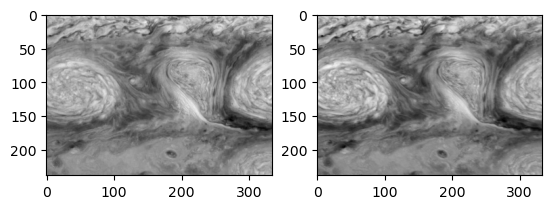

In [9]:
# %load OpenOpticalFlow_PIV_Run.py
"""
This Python program integrates the optical flow method with the cross-correlation method
for extraction of high-resolution velocity fields from particle images.
This hybrid method provides an additional tool to process PIV images,
which combines the advantages of the optical flow method and cross-correlation method.
"""

import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import os
import sys

# Import from openopticalflow package
from openopticalflow.correction_illumination import correction_illumination
from openopticalflow.pre_processing_a import pre_processing_a
from openopticalflow.OpticalFlowPhysics_fun import OpticalFlowPhysics_fun
from openopticalflow.shift_image_fun_refine_1 import shift_image_fun_refine_1

# Import PIV analysis functions
from pivSuite.pivAnalyzeImagePair import piv_analyze_image_pair

from visualization.plots_set_1 import plots_set_1
from visualization.plots_set_2 import plots_set_2
# %% Load Images
#
# % Im1=imread('I1_vortexpair_dt0p03.tif');
# % Im2=imread('I2_vortexpair_dt0p03.tif');
#
# % Im1=imread('I1_vortexpair_dt0p05.tif');
# % Im2=imread('I2_vortexpair_dt0p05.tif');
#
# % Im1=imread('wall_jet_1.tif');
# % Im2=imread('wall_jet_2.tif');
#
# % Im1=imread('twin_jet_1.tif');
# % Im2=imread('twin_jet_2.tif');
#
# Im1=imread('White_Oval_1.tif');
# Im2=imread('White_Oval_2.tif');

# Load images
try:
    Im1 = imageio.imread(os.path.join('images', 'White_Oval_1.tif')) 
    Im2 = imageio.imread(os.path.join('images', 'White_Oval_2.tif'))
    print("Successfully loaded White_Oval images")
except Exception as e:
    print(f"Error loading White_Oval images: {e}")
    sys.exit(1)

# %% Selete region of interest, "0" for processing the whole image, "1" for processing a selected region
# index_region=0;
#
# Im1=double(Im1);
# Im2=double(Im2);

# Select region of interest
index_region = 0
Im1 = Im1.astype(np.float64)
Im2 = Im2.astype(np.float64)

# if (index_region == 1)
#     imagesc(uint8(Im1));
#     colormap(gray);
#     axis image;
#
#     xy=ginput(2);
#     x1=floor(min(xy(:,1)));
#     x2=floor(max(xy(:,1)));
#     y1=floor(min(xy(:,2)));
#     y2=floor(max(xy(:,2)));
#     I1=double(Im1(y1:y2,x1:x2));
#     I2=double(Im2(y1:y2,x1:x2));
# elseif (index_region == 0)
#     I1=Im1;
#     I2=Im2;
# end

if index_region == 1:
    plt.imshow(Im1.astype(np.uint8), cmap='gray')
    plt.axis('image')
    xy = plt.ginput(2)
    plt.close()
    x1, x2 = int(np.floor(min(xy[0][0], xy[1][0]))), int(np.floor(max(xy[0][0], xy[1][0])))
    y1, y2 = int(np.floor(min(xy[0][1], xy[1][1]))), int(np.floor(max(xy[0][1], xy[1][1])))
    I1 = Im1[y1:y2, x1:x2]
    I2 = Im2[y1:y2, x1:x2]
elif index_region == 0:
    I1 = Im1
    I2 = Im2

# I1_original=I1;
# I2_original=I2;

I1_original = I1.copy()
I2_original = I2.copy()

fig, ax = plt.subplots(1,2)
ax[0].imshow(I1_original, cmap='gray')
ax[1].imshow(I2_original, cmap='gray')
plt.show()



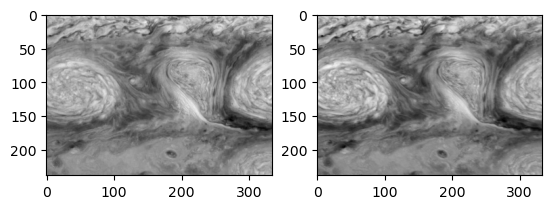

In [10]:


# %% Set the Parameters for Optical Flow Computation
#
# % Set the lagrange multipleirs in optical computation
# lambda_1=20;  % the Horn_schunck estimator for initial field
# lambda_2=2000; % the Liu-Shen estimator for refined estimation

# Set the Parameters for Optical Flow Computation
lambda_1 = 20    # the Horn_schunck estimator for initial field
lambda_2 = 2000  # the Liu-Shen estimator for refined estimation

# %% Number of iterations in the coarse-to-fine iterative process from
# %% initial estimation, "1" means 1 iteration
# no_iteration=1; % fixed

# Number of iterations in the coarse-to-fine iterative process
no_iteration = 1  # fixed

# %% Initial coarse field estimation in the coarse-to-fine iterative process,
# %% scale_im is a scale factor for down-sizing of images
# scale_im=1;
# %% For Image Pre-Processing
#
# %% For local illumination intensity adjustment, To bypass it, set size_average = 0
# size_average=0; % in pixels
#
# %% Gausian filter size for removing random noise in images
# size_filter=6; % in pixels

# Initial coarse field estimation parameters
scale_im = 1     # scale factor for down-sizing of images

# For local illumination intensity adjustment, To bypass it, set size_average = 0
size_average = 0  # in pixels

# Gaussian filter size for removing random noise in images
size_filter = 6  # in pixels

# %% correcting the global and local intensity change in images
# [m1,n1]=size(I1);
# window_shifting=[1;n1;1;m1]; % [x1,x2,y1,y2] deines a rectangular window for global intensity correction
# [I1,I2]=correction_illumination(I1,I2,window_shifting,size_average);

# Correcting the global and local intensity change in images
m1, n1 = I1.shape
window_shifting = [1, n1, 1, m1]  # [x1,x2,y1,y2] defines a rectangular window for global intensity correction
I1, I2 = correction_illumination(I1, I2, window_shifting, size_average)


fig, ax = plt.subplots(1,2)
ax[0].imshow(I1, cmap='gray')
ax[1].imshow(I2, cmap='gray')
plt.show()

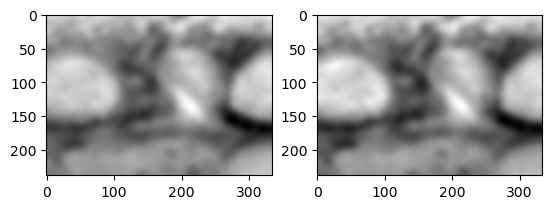

In [11]:

# %% cleaning the left and upper edges since some data near the edges are corrupted due to interperlation
# edge_width=1; % in pixels

# Cleaning the left and upper edges
edge_width = 1  # in pixels

# %% pre-processing for reducing random noise,
# %% and downsampling images if displacements are large
# [I1,I2] = pre_processing_a(I1,I2,scale_im,size_filter);
#
# I_region1=I1;
# I_region2=I2;

# Pre-processing for reducing random noise and downsampling images
I1, I2 = pre_processing_a(I1, I2, scale_im, size_filter)
I_region1 = I1.copy()
I_region2 = I2.copy()

fig, ax = plt.subplots(1,2)
ax[0].imshow(I_region1, cmap='gray')
ax[1].imshow(I_region2, cmap='gray')
plt.show()

In [12]:

# %% initial correlation calculation for a coarse-grained velocity field (ux0,uy0)
# % ux is the velocity (pixels/unit time) in the image x-coordinate (from the left-up corner to right)
# % uy is the velocity (pixels/unit time) in the image y-coordinate (from the left-up corner to bottom)
#
#
# %% run FFT cross-correlation algorithm
# Im1=I1;
# Im2=I2;
#
# pivPar.iaSizeX = [64 16 8];     % size of interrogation area in X
# pivPar.iaStepX = [32 8 4];       % grid spacing of velocity vectors in X
#
# pivPar.ccMethod = 'fft';
#
# [pivData1] = pivAnalyzeImagePair(Im1,Im2,pivPar);
#
# ux0=pivData1.U;
# uy0=pivData1.V;

# Run FFT cross-correlation algorithm for initial velocity field
Im1 = I1
Im2 = I2

# Set PIV parameters
pivPar = {
    'iaSizeX': [64, 16, 8],     # size of interrogation area in X
    'iaStepX': [32, 8, 4],      # grid spacing of velocity vectors in X
    'ccMethod': 'fft'
}

# Run PIV analysis
pivData1 = piv_analyze_image_pair(Im1, Im2, pivPar)
ux0 = pivData1['U']
uy0 = pivData1['V']

# Handle 3D arrays (if the result is a 3D array with a single time slice)
if len(ux0.shape) > 2:
    ux0 = ux0[:, :, 0]
    uy0 = uy0[:, :, 0]
    


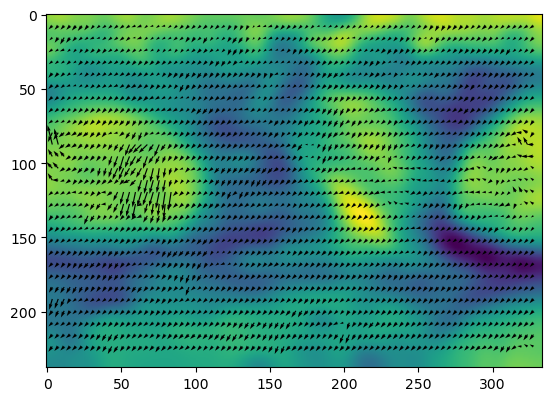

In [15]:
fig, ax = plt.subplots()
ax.imshow(I_region1)
ax.quiver(pivData1['X'], pivData1['Y'], ux0, uy0)
plt.show()

In [ ]:



# %% re-size the initial velocity dield (u0, v0)
# [n0,m0]=size(ux0);
# [n1,m1]=size(Im1);
#
# scale=round((n1*m1/(n0*m0))^0.5);
#
# ux0=imresize(ux0,scale);
# uy0=imresize(uy0,scale);

# Resize the initial velocity field
n0, m0 = ux0.shape
n1, m1 = Im1.shape

scale = round((n1 * m1 / (n0 * m0)) ** 0.5)

# Use scipy.ndimage.zoom for resizing (equivalent to MATLAB's imresize)
ux0 = zoom(ux0, scale)
uy0 = zoom(uy0, scale)

# %% generate the shifted image from Im1 based on the initial coarse-grained velocity field (ux0, uy0),
# %% and then calculate velocity difference for iterative correction
#
#
# %% estimate the displacement vector and make correction in iterations
#
# ux=ux0;
# uy=uy0;
#
# k=1;
# while k<=no_iteration
#    [Im1_shift,uxI,uyI]=shift_image_fun_refine_1(ux,uy,Im1,Im2);
#
#     I1=double(Im1_shift);
#     I2=double(Im2);
#
#     % calculation of correction of the optical flow
#     [dux,duy,vor,dux_horn,duy_horn,error2]=OpticalFlowPhysics_fun(I1,I2,lambda_1,lambda_2);
#
#     % refined optical flow
#     ux_corr=uxI+dux;
#     uy_corr=uyI+duy;
#
#
#     k=k+1;
# end

# Generate the shifted image and calculate velocity difference iteratively
ux = ux0.copy()
uy = uy0.copy()

k = 1
while k <= no_iteration:
    print(f"Iteration {k}/{no_iteration}")
    Im1_shift, uxI, uyI = shift_image_fun_refine_1(ux, uy, Im1, Im2)
    
    I1 = Im1_shift.astype(np.float64)
    I2 = Im2.astype(np.float64)
    
    # Calculation of correction of the optical flow
    dux, duy, vor, dux_horn, duy_horn, error2 = OpticalFlowPhysics_fun(I1, I2, lambda_1, lambda_2)
    
    # Refined optical flow
    ux_corr = uxI + dux
    uy_corr = uyI + duy
    
    k += 1

# %% refined velocity field
# ux = ux_corr;    %%%%%
# uy = uy_corr;    %%%%%

# Refined velocity field
ux = ux_corr
uy = uy_corr

# %% clean up the edges
# ux(:,1:edge_width)=ux(:,(edge_width+1):(2*edge_width));
# uy(:,1:edge_width)=uy(:,(edge_width+1):(2*edge_width));
#
# ux(1:edge_width,:)=ux((edge_width+1):(2*edge_width),:);
# uy(1:edge_width,:)=uy((edge_width+1):(2*edge_width),:);

# Clean up the edges
ux[:, :edge_width] = ux[:, edge_width:2*edge_width]
uy[:, :edge_width] = uy[:, edge_width:2*edge_width]
ux[:edge_width, :] = ux[edge_width:2*edge_width, :]
uy[:edge_width, :] = uy[edge_width:2*edge_width, :]

# %% show the images and processed results
# %% plot the images, velocity vector, and streamlines in the initail and
# %% refined estimations
#  plots_set_1;
#
# %% plot the fields of velocity magnitude, vorticity and the second invariant Q
#  plots_set_2;

# Show the images and processed results
# print("Analysis complete. To visualize results, use:")
# print("from visualization.plots_set_1 import plots_set_1")
# print("from visualization.plots_set_2 import plots_set_2")
# print("plots_set_1(I_region1, I_region2, ux0, uy0, Im1, Im2, ux, uy)")
# print("plots_set_2(ux, uy)")

# % save Ux_vortexpair_hybrid_dt0p2.dat ux -ascii;
# % save Uy_vortexpair_hybrid_dt0p2.dat uy -ascii;
# %
# % save Ux_vortexpair_corr_dt0p2.dat ux0 -ascii;
# % save Uy_vortexpair_corr_dt0p2.dat uy0 -ascii;

# Save results if needed
# np.savetxt('Ux_vortexpair_hybrid_dt0p2.dat', ux)
# np.savetxt('Uy_vortexpair_hybrid_dt0p2.dat', uy)
# np.savetxt('Ux_vortexpair_corr_dt0p2.dat', ux0)
# np.savetxt('Uy_vortexpair_corr_dt0p2.dat', uy0)

# Return results for further analysis
results = {
    'ux': ux,
    'uy': uy,
    'ux0': ux0,
    'uy0': uy0,
    'I1': I1,
    'I2': I2,
    'I_region1': I_region1,
    'I_region2': I_region2,
    'Im1': Im1,
    'Im2': Im2
}


# % save Ux_vortexpair_hybrid_dt0p2.dat ux -ascii;
# % save Uy_vortexpair_hybrid_dt0p2.dat uy -ascii;
# %
# % save Ux_vortexpair_corr_dt0p2.dat ux0 -ascii;
# % save Uy_vortexpair_corr_dt0p2.dat uy0 -ascii;

# Save results if needed
# np.savetxt('Ux_vortexpair_hybrid_dt0p2.dat', ux)
# np.savetxt('Uy_vortexpair_hybrid_dt0p2.dat', uy)
# np.savetxt('Ux_vortexpair_corr_dt0p2.dat', ux0)
# np.savetxt('Uy_vortexpair_corr_dt0p2.dat', uy0)

# Return results for further analysis
results = {
    'ux': ux,
    'uy': uy,
    'ux0': ux0,
    'uy0': uy0,
    'I1': I1,
    'I2': I2,
    'I_region1': I_region1,
    'I_region2': I_region2,
    'Im1': Im1,
    'Im2': Im2
}


print("Analysis complete. Results stored in 'results' dictionary.")
print("Running visualization")
plots_set_1(results['I_region1'], results['I_region2'], results['ux0'], results['uy0'], results['Im1'], results['Im2'], results['ux'], results['uy'])
plots_set_2(results['ux'], results['uy'])


In [ ]:

# Import from openopticalflow package
from openopticalflow.correction_illumination import correction_illumination
from openopticalflow.pre_processing_a import pre_processing_a
from openopticalflow.OpticalFlowPhysics_fun import OpticalFlowPhysics_fun
from openopticalflow.shift_image_fun_refine_1 import shift_image_fun_refine_1

# Import PIV analysis functions
from pivSuite.pivAnalyzeImagePair import piv_analyze_image_pair

from visualization.plots_set_1 import plots_set_1
from visualization.plots_set_2 import plots_set_2
# %% Load Images
#
# % Im1=imread('I1_vortexpair_dt0p03.tif');
# % Im2=imread('I2_vortexpair_dt0p03.tif');
#
# % Im1=imread('I1_vortexpair_dt0p05.tif');
# % Im2=imread('I2_vortexpair_dt0p05.tif');
#
# % Im1=imread('wall_jet_1.tif');
# % Im2=imread('wall_jet_2.tif');
#
# % Im1=imread('twin_jet_1.tif');
# % Im2=imread('twin_jet_2.tif');
#
# Im1=imread('White_Oval_1.tif');
# Im2=imread('White_Oval_2.tif');

# Load images
try:
    Im1 = imageio.imread(os.path.join(local_dir, 'images', 'White_Oval_1.tif')) 
    Im2 = imageio.imread(os.path.join(local_dir, 'images', 'White_Oval_2.tif'))
    print("Successfully loaded White_Oval images")
except Exception as e:
    print(f"Error loading White_Oval images: {e}")
    sys.exit(1)

# %% Selete region of interest, "0" for processing the whole image, "1" for processing a selected region
# index_region=0;
#
# Im1=double(Im1);
# Im2=double(Im2);

# Select region of interest
index_region = 0
Im1 = Im1.astype(np.float64)
Im2 = Im2.astype(np.float64)

# if (index_region == 1)
#     imagesc(uint8(Im1));
#     colormap(gray);
#     axis image;
#
#     xy=ginput(2);
#     x1=floor(min(xy(:,1)));
#     x2=floor(max(xy(:,1)));
#     y1=floor(min(xy(:,2)));
#     y2=floor(max(xy(:,2)));
#     I1=double(Im1(y1:y2,x1:x2));
#     I2=double(Im2(y1:y2,x1:x2));
# elseif (index_region == 0)
#     I1=Im1;
#     I2=Im2;
# end

if index_region == 1:
    plt.imshow(Im1.astype(np.uint8), cmap='gray')
    plt.axis('image')
    xy = plt.ginput(2)
    plt.close()
    x1, x2 = int(np.floor(min(xy[0][0], xy[1][0]))), int(np.floor(max(xy[0][0], xy[1][0])))
    y1, y2 = int(np.floor(min(xy[0][1], xy[1][1]))), int(np.floor(max(xy[0][1], xy[1][1])))
    I1 = Im1[y1:y2, x1:x2]
    I2 = Im2[y1:y2, x1:x2]
elif index_region == 0:
    I1 = Im1
    I2 = Im2

# I1_original=I1;
# I2_original=I2;

I1_original = I1.copy()
I2_original = I2.copy()

# %% Set the Parameters for Optical Flow Computation
#
# % Set the lagrange multipleirs in optical computation
# lambda_1=20;  % the Horn_schunck estimator for initial field
# lambda_2=2000; % the Liu-Shen estimator for refined estimation

# Set the Parameters for Optical Flow Computation
lambda_1 = 20    # the Horn_schunck estimator for initial field
lambda_2 = 2000  # the Liu-Shen estimator for refined estimation

# %% Number of iterations in the coarse-to-fine iterative process from
# %% initial estimation, "1" means 1 iteration
# no_iteration=1; % fixed

# Number of iterations in the coarse-to-fine iterative process
no_iteration = 1  # fixed

# %% Initial coarse field estimation in the coarse-to-fine iterative process,
# %% scale_im is a scale factor for down-sizing of images
# scale_im=1;
# %% For Image Pre-Processing
#
# %% For local illumination intensity adjustment, To bypass it, set size_average = 0
# size_average=0; % in pixels
#
# %% Gausian filter size for removing random noise in images
# size_filter=6; % in pixels

# Initial coarse field estimation parameters
scale_im = 1     # scale factor for down-sizing of images

# For local illumination intensity adjustment, To bypass it, set size_average = 0
size_average = 0  # in pixels

# Gaussian filter size for removing random noise in images
size_filter = 6  # in pixels

# %% correcting the global and local intensity change in images
# [m1,n1]=size(I1);
# window_shifting=[1;n1;1;m1]; % [x1,x2,y1,y2] deines a rectangular window for global intensity correction
# [I1,I2]=correction_illumination(I1,I2,window_shifting,size_average);

# Correcting the global and local intensity change in images
m1, n1 = I1.shape
window_shifting = [1, n1, 1, m1]  # [x1,x2,y1,y2] defines a rectangular window for global intensity correction
I1, I2 = correction_illumination(I1, I2, window_shifting, size_average)

# %% cleaning the left and upper edges since some data near the edges are corrupted due to interperlation
# edge_width=1; % in pixels

# Cleaning the left and upper edges
edge_width = 1  # in pixels

# %% pre-processing for reducing random noise,
# %% and downsampling images if displacements are large
# [I1,I2] = pre_processing_a(I1,I2,scale_im,size_filter);
#
# I_region1=I1;
# I_region2=I2;

# Pre-processing for reducing random noise and downsampling images
I1, I2 = pre_processing_a(I1, I2, scale_im, size_filter)
I_region1 = I1.copy()
I_region2 = I2.copy()

# %% initial correlation calculation for a coarse-grained velocity field (ux0,uy0)
# % ux is the velocity (pixels/unit time) in the image x-coordinate (from the left-up corner to right)
# % uy is the velocity (pixels/unit time) in the image y-coordinate (from the left-up corner to bottom)
#
#
# %% run FFT cross-correlation algorithm
# Im1=I1;
# Im2=I2;
#
# pivPar.iaSizeX = [64 16 8];     % size of interrogation area in X
# pivPar.iaStepX = [32 8 4];       % grid spacing of velocity vectors in X
#
# pivPar.ccMethod = 'fft';
#
# [pivData1] = pivAnalyzeImagePair(Im1,Im2,pivPar);
#
# ux0=pivData1.U;
# uy0=pivData1.V;

# Run FFT cross-correlation algorithm for initial velocity field
Im1 = I1
Im2 = I2

# Set PIV parameters
pivPar = {
    'iaSizeX': [64, 16, 8],     # size of interrogation area in X
    'iaStepX': [32, 8, 4],      # grid spacing of velocity vectors in X
    'ccMethod': 'fft'
}

# Run PIV analysis
pivData1 = piv_analyze_image_pair(Im1, Im2, pivPar)
ux0 = pivData1['U']
uy0 = pivData1['V']

# Handle 3D arrays (if the result is a 3D array with a single time slice)
if len(ux0.shape) > 2:
    ux0 = ux0[:, :, 0]
    uy0 = uy0[:, :, 0]

# %% re-size the initial velocity dield (u0, v0)
# [n0,m0]=size(ux0);
# [n1,m1]=size(Im1);
#
# scale=round((n1*m1/(n0*m0))^0.5);
#
# ux0=imresize(ux0,scale);
# uy0=imresize(uy0,scale);

# Resize the initial velocity field
n0, m0 = ux0.shape
n1, m1 = Im1.shape

scale = round((n1 * m1 / (n0 * m0)) ** 0.5)

# Use scipy.ndimage.zoom for resizing (equivalent to MATLAB's imresize)
ux0 = zoom(ux0, scale)
uy0 = zoom(uy0, scale)

# %% generate the shifted image from Im1 based on the initial coarse-grained velocity field (ux0, uy0),
# %% and then calculate velocity difference for iterative correction
#
#
# %% estimate the displacement vector and make correction in iterations
#
# ux=ux0;
# uy=uy0;
#
# k=1;
# while k<=no_iteration
#    [Im1_shift,uxI,uyI]=shift_image_fun_refine_1(ux,uy,Im1,Im2);
#
#     I1=double(Im1_shift);
#     I2=double(Im2);
#
#     % calculation of correction of the optical flow
#     [dux,duy,vor,dux_horn,duy_horn,error2]=OpticalFlowPhysics_fun(I1,I2,lambda_1,lambda_2);
#
#     % refined optical flow
#     ux_corr=uxI+dux;
#     uy_corr=uyI+duy;
#
#
#     k=k+1;
# end

# Generate the shifted image and calculate velocity difference iteratively
ux = ux0.copy()
uy = uy0.copy()

k = 1
while k <= no_iteration:
    print(f"Iteration {k}/{no_iteration}")
    Im1_shift, uxI, uyI = shift_image_fun_refine_1(ux, uy, Im1, Im2)
    
    I1 = Im1_shift.astype(np.float64)
    I2 = Im2.astype(np.float64)
    
    # Calculation of correction of the optical flow
    dux, duy, vor, dux_horn, duy_horn, error2 = OpticalFlowPhysics_fun(I1, I2, lambda_1, lambda_2)
    
    # Refined optical flow
    ux_corr = uxI + dux
    uy_corr = uyI + duy
    
    k += 1

# %% refined velocity field
# ux = ux_corr;    %%%%%
# uy = uy_corr;    %%%%%

# Refined velocity field
ux = ux_corr
uy = uy_corr

# %% clean up the edges
# ux(:,1:edge_width)=ux(:,(edge_width+1):(2*edge_width));
# uy(:,1:edge_width)=uy(:,(edge_width+1):(2*edge_width));
#
# ux(1:edge_width,:)=ux((edge_width+1):(2*edge_width),:);
# uy(1:edge_width,:)=uy((edge_width+1):(2*edge_width),:);

# Clean up the edges
ux[:, :edge_width] = ux[:, edge_width:2*edge_width]
uy[:, :edge_width] = uy[:, edge_width:2*edge_width]
ux[:edge_width, :] = ux[edge_width:2*edge_width, :]
uy[:edge_width, :] = uy[edge_width:2*edge_width, :]

# %% show the images and processed results
# %% plot the images, velocity vector, and streamlines in the initail and
# %% refined estimations
#  plots_set_1;
#
# %% plot the fields of velocity magnitude, vorticity and the second invariant Q
#  plots_set_2;

# Show the images and processed results
# print("Analysis complete. To visualize results, use:")
# print("from visualization.plots_set_1 import plots_set_1")
# print("from visualization.plots_set_2 import plots_set_2")
# print("plots_set_1(I_region1, I_region2, ux0, uy0, Im1, Im2, ux, uy)")
# print("plots_set_2(ux, uy)")

# % save Ux_vortexpair_hybrid_dt0p2.dat ux -ascii;
# % save Uy_vortexpair_hybrid_dt0p2.dat uy -ascii;
# %
# % save Ux_vortexpair_corr_dt0p2.dat ux0 -ascii;
# % save Uy_vortexpair_corr_dt0p2.dat uy0 -ascii;

# Save results if needed
# np.savetxt('Ux_vortexpair_hybrid_dt0p2.dat', ux)
# np.savetxt('Uy_vortexpair_hybrid_dt0p2.dat', uy)
# np.savetxt('Ux_vortexpair_corr_dt0p2.dat', ux0)
# np.savetxt('Uy_vortexpair_corr_dt0p2.dat', uy0)

# Return results for further analysis
results = {
    'ux': ux,
    'uy': uy,
    'ux0': ux0,
    'uy0': uy0,
    'I1': I1,
    'I2': I2,
    'I_region1': I_region1,
    'I_region2': I_region2,
    'Im1': Im1,
    'Im2': Im2
}


# % save Ux_vortexpair_hybrid_dt0p2.dat ux -ascii;
# % save Uy_vortexpair_hybrid_dt0p2.dat uy -ascii;
# %
# % save Ux_vortexpair_corr_dt0p2.dat ux0 -ascii;
# % save Uy_vortexpair_corr_dt0p2.dat uy0 -ascii;

# Save results if needed
# np.savetxt('Ux_vortexpair_hybrid_dt0p2.dat', ux)
# np.savetxt('Uy_vortexpair_hybrid_dt0p2.dat', uy)
# np.savetxt('Ux_vortexpair_corr_dt0p2.dat', ux0)
# np.savetxt('Uy_vortexpair_corr_dt0p2.dat', uy0)

# Return results for further analysis
results = {
    'ux': ux,
    'uy': uy,
    'ux0': ux0,
    'uy0': uy0,
    'I1': I1,
    'I2': I2,
    'I_region1': I_region1,
    'I_region2': I_region2,
    'Im1': Im1,
    'Im2': Im2
}


print("Analysis complete. Results stored in 'results' dictionary.")
print("Running visualization")
plots_set_1(results['I_region1'], results['I_region2'], results['ux0'], results['uy0'], results['Im1'], results['Im2'], results['ux'], results['uy'])
plots_set_2(results['ux'], results['uy'])
